In [1]:
# Libraries
import pandas as pd
import numpy as np
import re
import hashlib
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D



pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
data = pd.read_csv(r'C:\Users\USER\Desktop\Projects\Data Science\Centralized Data Platform\Snowflakes\RENT_extract.csv')

data.head(2)

,_AIRBYTE_RAW_ID,_AIRBYTE_EXTRACTED_AT,_AIRBYTE_META,_AIRBYTE_GENERATION_ID,ID,HOA,CITY,PRICE,STATE,COUNTY,STATUS,HISTORY,LOTSIZE,MLSNAME,ZIPCODE,BEDROOMS,LATITUDE,BATHROOMS,LONGITUDE,MLSNUMBER,STATEFIPS,YEARBUILT,COUNTYFIPS,LISTEDDATE,CREATEDDATE,LISTINGTYPE,REMOVEDDATE,ADDRESSLINE1,ADDRESSLINE2,DAYSONMARKET,LASTSEENDATE,LISTINGAGENT,PROPERTYTYPE,LISTINGOFFICE,SQUAREFOOTAGE,FORMATTEDADDRESS,_AB_SOURCE_FILE_URL,_AB_SOURCE_FILE_LAST_MODIFIED
0,019bcd87-1759-7764-a338-b78e51ec8035,2026-01-17 11:55:38.906000-08:00,"{\n ""changes"": [],\n ""sync_id"": 66499749\n}",0,"1013-Fieldwood-Dr,-Unit-B,-Austin,-TX-78758",NaN,Austin,1395,TX,Travis,Active,"{'2025-12-04': {'event': 'Rental Listing', 'pr...",7013.0,UnlockMLS,78758,2.0,30.370937,1.0,-97.699005,4890343,48,1980.0,453.0,2025-12-04T00:00:00.000Z,2021-11-16T03:13:53.750Z,Standard,NaN,1013 Fieldwood Dr,Unit B,45,2026-01-17T03:16:47.432Z,"{'name': 'Flora Huang', 'phone': '5127519964',...",Multi-Family,"{'name': 'Evergreen Company', 'phone': '512331...",825.0,"1013 Fieldwood Dr, Unit B, Austin, TX 78758",raw/rentcast/rental_listings/2026/rentcast_ren...,2026-01-17T16:04:13.000000Z
1,019bcd87-1709-7ece-ab1f-08558b95c7b5,2026-01-17 11:55:38.902000-08:00,"{\n ""changes"": [],\n ""sync_id"": 66499749\n}",0,"6814-E-Riverside-Dr,-Unit-95,-Austin,-TX-78741",NaN,Austin,2400,TX,Travis,Active,"{'2025-12-02': {'event': 'Rental Listing', 'pr...",NaN,UnlockMLS,78741,3.0,30.223478,2.5,-97.699338,5307516,48,2018.0,453.0,2025-12-02T00:00:00.000Z,2021-09-12T03:16:04.876Z,Standard,NaN,6814 E Riverside Dr,Unit 95,47,2026-01-17T03:16:47.547Z,"{'name': 'Kiran Kamboj', 'phone': '5129707564'...",Condo,"{'name': 'Trinity Texas Realty Inc', 'phone': ...",1642.0,"6814 E Riverside Dr, Unit 95, Austin, TX 78741",raw/rentcast/rental_listings/2026/rentcast_ren...,2026-01-17T16:04:13.000000Z


**DATA TRANSFORMATION**

In [3]:
# Transform nested/text-encoded fields (HISTORY, LISTINGAGENT, LISTINGOFFICE) 

def safe_literal_dict(x):
    """Safely convert a python-dict-like string to a dict."""
    if pd.isna(x) or str(x).strip() == "":
        return {}
    try:
        return ast.literal_eval(x)
    except Exception:
        return {}

# A) Extract EVENT from HISTORY (latest entry) 
def extract_latest_event(hist):
    if not isinstance(hist, dict) or len(hist) == 0:
        return None
    latest_date = sorted(hist.keys())[-1]
    payload = hist.get(latest_date, {})
    return payload.get("event") if isinstance(payload, dict) else None

hist_dict = data["HISTORY"].apply(safe_literal_dict)
data["EVENT"] = hist_dict.apply(extract_latest_event)
data = data.drop(columns=["HISTORY"], errors="ignore")

# B) Split LISTINGAGENT into LISTINGAGENT_* columns (uppercase) 
agent_dict = data["LISTINGAGENT"].apply(safe_literal_dict)
agent_cols = pd.json_normalize(agent_dict)
agent_cols.columns = [f"LISTINGAGENT_{c}".upper() for c in agent_cols.columns]

data = pd.concat([data.drop(columns=["LISTINGAGENT"], errors="ignore"), agent_cols], axis=1)

# C) Split LISTINGOFFICE into LISTINGOFFICE_* columns (uppercase)
office_dict = data["LISTINGOFFICE"].apply(safe_literal_dict)
office_cols = pd.json_normalize(office_dict)
office_cols.columns = [f"LISTINGOFFICE_{c}".upper() for c in office_cols.columns]

data = pd.concat([data.drop(columns=["LISTINGOFFICE"], errors="ignore"), office_cols], axis=1)

data.head(2)

,_AIRBYTE_RAW_ID,_AIRBYTE_EXTRACTED_AT,_AIRBYTE_META,_AIRBYTE_GENERATION_ID,ID,HOA,CITY,PRICE,STATE,COUNTY,STATUS,LOTSIZE,MLSNAME,ZIPCODE,BEDROOMS,LATITUDE,BATHROOMS,LONGITUDE,MLSNUMBER,STATEFIPS,YEARBUILT,COUNTYFIPS,LISTEDDATE,CREATEDDATE,LISTINGTYPE,REMOVEDDATE,ADDRESSLINE1,ADDRESSLINE2,DAYSONMARKET,LASTSEENDATE,PROPERTYTYPE,SQUAREFOOTAGE,FORMATTEDADDRESS,_AB_SOURCE_FILE_URL,_AB_SOURCE_FILE_LAST_MODIFIED,EVENT,LISTINGAGENT_NAME,LISTINGAGENT_PHONE,LISTINGAGENT_EMAIL,LISTINGAGENT_WEBSITE,LISTINGOFFICE_NAME,LISTINGOFFICE_PHONE,LISTINGOFFICE_EMAIL,LISTINGOFFICE_WEBSITE
0,019bcd87-1759-7764-a338-b78e51ec8035,2026-01-17 11:55:38.906000-08:00,"{\n ""changes"": [],\n ""sync_id"": 66499749\n}",0,"1013-Fieldwood-Dr,-Unit-B,-Austin,-TX-78758",NaN,Austin,1395,TX,Travis,Active,7013.0,UnlockMLS,78758,2.0,30.370937,1.0,-97.699005,4890343,48,1980.0,453.0,2025-12-04T00:00:00.000Z,2021-11-16T03:13:53.750Z,Standard,NaN,1013 Fieldwood Dr,Unit B,45,2026-01-17T03:16:47.432Z,Multi-Family,825.0,"1013 Fieldwood Dr, Unit B, Austin, TX 78758",raw/rentcast/rental_listings/2026/rentcast_ren...,2026-01-17T16:04:13.000000Z,Rental Listing,Flora Huang,5127519964,flora.evergreen@gmail.com,NaN,Evergreen Company,5123311122,NaN,NaN
1,019bcd87-1709-7ece-ab1f-08558b95c7b5,2026-01-17 11:55:38.902000-08:00,"{\n ""changes"": [],\n ""sync_id"": 66499749\n}",0,"6814-E-Riverside-Dr,-Unit-95,-Austin,-TX-78741",NaN,Austin,2400,TX,Travis,Active,NaN,UnlockMLS,78741,3.0,30.223478,2.5,-97.699338,5307516,48,2018.0,453.0,2025-12-02T00:00:00.000Z,2021-09-12T03:16:04.876Z,Standard,NaN,6814 E Riverside Dr,Unit 95,47,2026-01-17T03:16:47.547Z,Condo,1642.0,"6814 E Riverside Dr, Unit 95, Austin, TX 78741",raw/rentcast/rental_listings/2026/rentcast_ren...,2026-01-17T16:04:13.000000Z,Rental Listing,Kiran Kamboj,5129707564,kiran@trinitytxrealty.com,NaN,Trinity Texas Realty Inc,5122794596,sijo@indusrealty.com,www.trinitytexasrealty.com


In [5]:
import os
# # Save the cleaned data into the 'model' folder
# Relative path from current directory to model folder
save_path = "../Data cleaning/transformed_data.csv"

# Ensure directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save cleaned data
data.to_csv(save_path, index=False)

**COLUMNS TO DROP FOR ANALYTICS**

In [148]:
# Summary of null percentages and unique values
summary = pd.DataFrame({
    "null_pct": (data.isna().mean()*100).round(1),
    "unique": data.nunique(dropna=True)
}).sort_values(["null_pct","unique"], ascending=[False, True])

print(summary)

                               null_pct  unique
REMOVEDDATE                       100.0       0
HOA                                99.4     123
LISTINGAGENT_WEBSITE               94.0     979
LISTINGOFFICE_WEBSITE              93.3     601
LOTSIZE                            88.4     936
LISTINGOFFICE_EMAIL                87.9    1151
LISTINGAGENT_PHONE                 86.8    1985
LISTINGAGENT_EMAIL                 86.8    2059
LISTINGOFFICE_PHONE                86.6    1401
LISTINGAGENT_NAME                  86.2    2153
MLSNAME                            86.1      58
LISTINGOFFICE_NAME                 86.1    1349
MLSNUMBER                          86.1    3396
YEARBUILT                          74.7     170
ADDRESSLINE2                       49.3    5131
SQUAREFOOTAGE                      14.2    2635
BATHROOMS                           0.6      18
COUNTYFIPS                          0.4      80
BEDROOMS                            0.3      12
_AIRBYTE_GENERATION_ID              0.0 

In [149]:
# Columns to drop from the analytics dataset (but keep in raw)
col_to_drop_for_analytics = [
    # ingestion / lineage metadata (keep only in raw)
    "_AIRBYTE_RAW_ID",
    "_AIRBYTE_EXTRACTED_AT",
    "_AIRBYTE_META",
    "_AIRBYTE_GENERATION_ID",
    "_AB_SOURCE_FILE_URL",
    "_AB_SOURCE_FILE_LAST_MODIFIED",

    # agent/office fields (mostly-missing operational/source fields -keep only in raw)
    "LISTINGAGENT_NAME", 
    "LISTINGAGENT_PHONE", 
    "LISTINGAGENT_EMAIL", 
    "LISTINGAGENT_WEBSITE",
    "LISTINGOFFICE_NAME",   
    "LISTINGOFFICE_PHONE",
    "LISTINGOFFICE_EMAIL",
    "LISTINGOFFICE_WEBSITE",

    # MLS identifiers (source tracing, not market features)
    "MLSNUMBER", #(86.1% null)
    "MLSNAME",  #(86.1% null)

    # # Redundant Identifier & address columns
    "ID", 
    "FORMATTEDADDRESS",

    # No need of unit/unit address detail
    "ADDRESSLINE2",

    # Constant column with no analytical signal (unique=1) 
    "STATUS",
    "EVENT",

    # High null% and low unique values
    "REMOVEDDATE",   # 100% null
    "HOA",           # 99.4% null
    "LOTSIZE",       # 88.4% null
    "YEARBUILT"      # 74.7% null
]
data = data.drop(columns=col_to_drop_for_analytics, errors="ignore") # include errors=ignore to avoid future crash if column not found


The pipeline metadata are dropped because they are not analytical variables. They are only created by the ingestion tool (Airbyte) to help with syncing, debugging, and auditability, but do not describe the rental listing itself. Others are on high null percentage.

**CHANGE DATE TO DATETIME**

In [150]:
# Convert date columns to datetime format
date_cols = ['LISTEDDATE', 'CREATEDDATE', 'LASTSEENDATE']

for c in date_cols:
    data[c] = pd.to_datetime(data[c], utc=True, errors="coerce").dt.strftime("%Y-%m-%d")

data.head(2)

,CITY,PRICE,STATE,COUNTY,ZIPCODE,BEDROOMS,LATITUDE,BATHROOMS,LONGITUDE,STATEFIPS,COUNTYFIPS,LISTEDDATE,CREATEDDATE,LISTINGTYPE,ADDRESSLINE1,DAYSONMARKET,LASTSEENDATE,PROPERTYTYPE,SQUAREFOOTAGE
0,Austin,1395,TX,Travis,78758,2.0,30.370937,1.0,-97.699005,48,453.0,2025-12-04,2021-11-16,Standard,1013 Fieldwood Dr,45,2026-01-17,Multi-Family,825.0
1,Austin,2400,TX,Travis,78741,3.0,30.223478,2.5,-97.699338,48,453.0,2025-12-02,2021-09-12,Standard,6814 E Riverside Dr,47,2026-01-17,Condo,1642.0


In [151]:
data.shape

(24411, 19)

**CHECK DATA INFORMATION & QUALITY**

In [152]:
# Display final data info
list_data = [
    ("data", data)
]

for name, data in list_data:
    print(name)
    print(f"Missing %: {round(data.isnull().mean() * 100, 2)}\n")
    
    print("Duplicated rows:", data.duplicated().sum())
    
    print("\nNumerical Summary:")
    print(data.describe())
    
    print("\nCategorical Summary:")
    print(data.describe(include=["O", "category"]))

    print("\nInfo:")
    print(data.info())
    
    print("*" * 100)


data
Missing %: CITY              0.00
PRICE             0.00
STATE             0.00
COUNTY            0.00
ZIPCODE           0.00
BEDROOMS          0.32
LATITUDE          0.00
BATHROOMS         0.56
LONGITUDE         0.00
STATEFIPS         0.00
COUNTYFIPS        0.41
LISTEDDATE        0.00
CREATEDDATE       0.00
LISTINGTYPE       0.00
ADDRESSLINE1      0.00
DAYSONMARKET      0.00
LASTSEENDATE      0.00
PROPERTYTYPE      0.00
SQUAREFOOTAGE    14.23
dtype: float64

Duplicated rows: 366

Numerical Summary:
              PRICE       ZIPCODE      BEDROOMS      LATITUDE     BATHROOMS  \
count  24411.000000  24411.000000  24333.000000  24411.000000  24274.000000   
mean    2109.958216  50044.960633      2.133317     39.338387      1.534049   
std     1611.106640  30249.165054      1.171851      6.208194      0.721557   
min      250.000000   2111.000000      0.000000     21.258263      0.500000   
25%     1250.000000  25801.000000      1.000000     35.164389      1.000000   
50%     1745.000

**ANALYSIS:** 

Missing Values: BEDROOMS (0.32), BATHROOMS (0.56), COUNTYFIPS (0.41) and SQUAREFOOTAGE (14.23)

Duplicated rows - 366

The min/max values in Numerical summary explain the “outliers” list. A few are clearly wrong and should be treated as data errors and not just capped.

PRICE: The price range from min 250 to max 20,000 is high and show plausible (luxury rentals exist).

**Columns that require Rule-based clip:**

DAYSONMARKET: The range from 1 to 3,040 is extreme, but could be referred to as stale listings.

BEDROOMS: The range from 0 to 12 is plausible.

BATHROOMS: The range from 0.5 to 10 is plausible.

**Columns that require fixing or removal:**

LATITUDE: The range from 21.26 to 64.90 is far north (not Austin). This could likely be a bad geographic information.

LONGITUDE: The range from -158.21 to 41.86 is not a valid geolocation does not represent US longitude because -158 is Hawaii. For Austin, we expect roughly approx. 30 latitude and approx -97 longitude.

SQUAREFOOTAGE max = 100,000,000 is definitely data error or input issue and should be removed or set to missing

**Column that is not an outlier concept:**

COUNTYFIPS: The range from 1 to 790 is a code range and does not need capping but validation.

**OUTLIER DETECTION**

Dataset: data
Column: PRICE, Outliers: 463
--------------------------------------------------
Column: ZIPCODE, Outliers: 0
--------------------------------------------------
Column: BEDROOMS, Outliers: 147
--------------------------------------------------
Column: LATITUDE, Outliers: 488
--------------------------------------------------
Column: BATHROOMS, Outliers: 251
--------------------------------------------------
Column: LONGITUDE, Outliers: 501
--------------------------------------------------
Column: STATEFIPS, Outliers: 0
--------------------------------------------------
Column: COUNTYFIPS, Outliers: 1149
--------------------------------------------------
Column: DAYSONMARKET, Outliers: 686
--------------------------------------------------
Column: SQUAREFOOTAGE, Outliers: 1
--------------------------------------------------
__________________________________________________


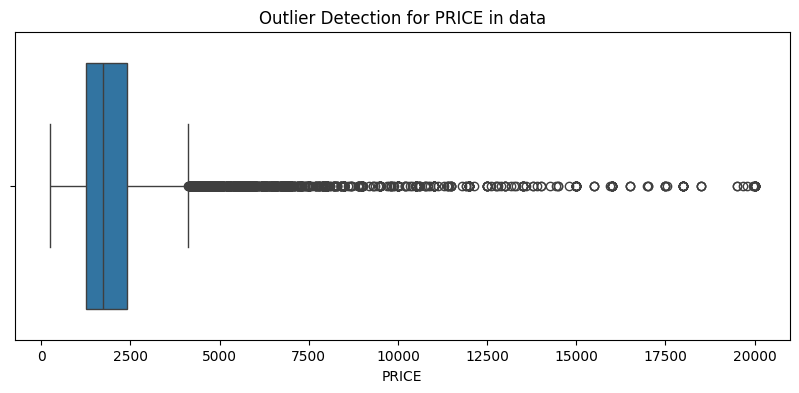

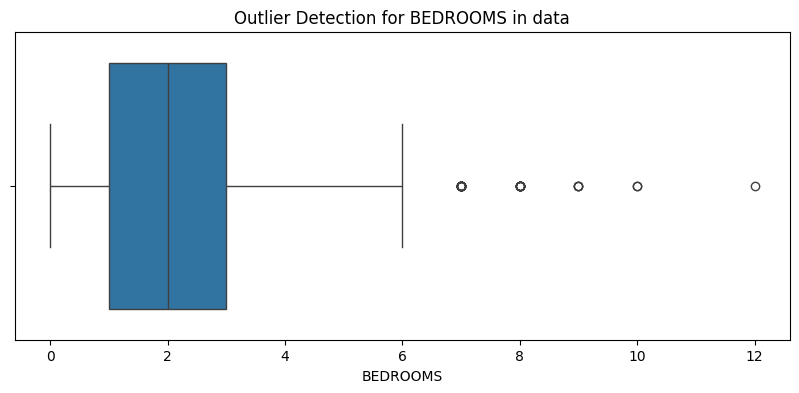

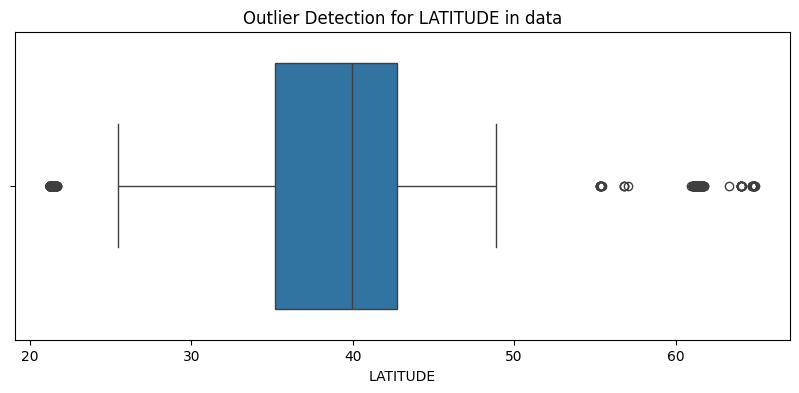

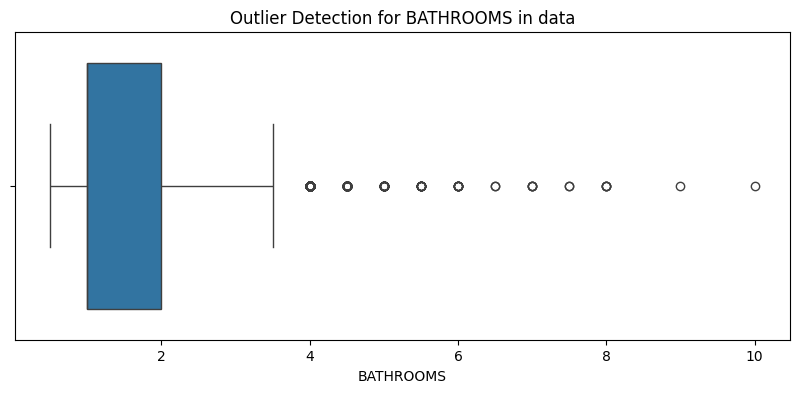

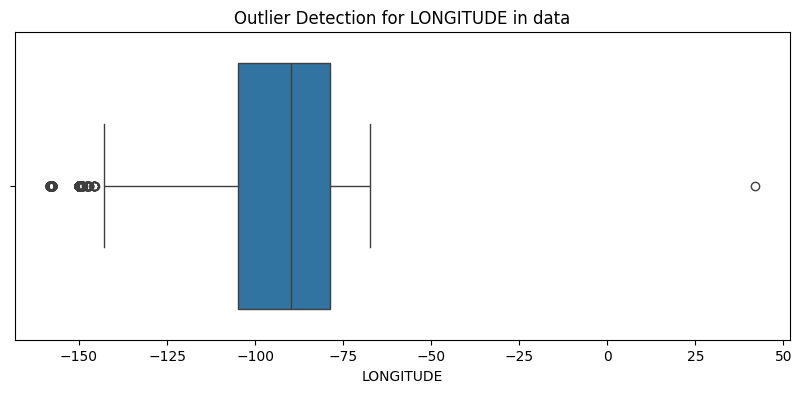

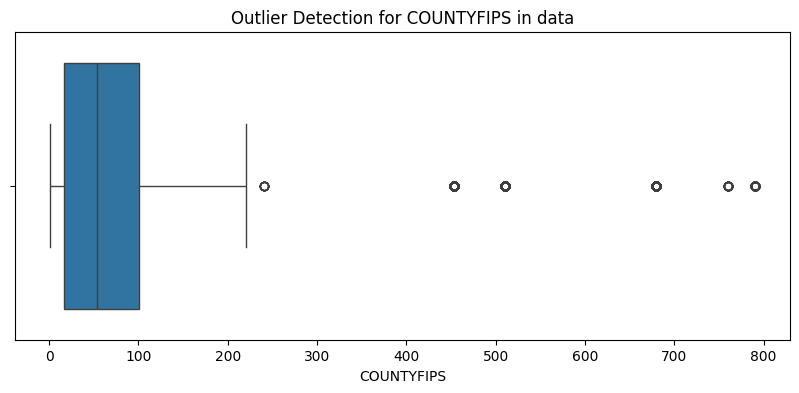

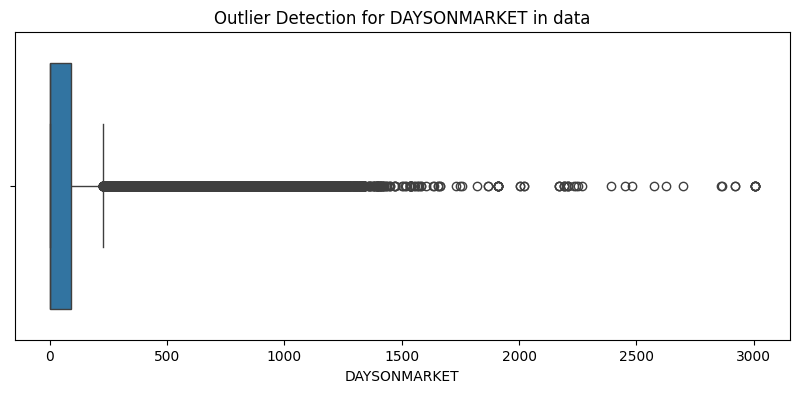

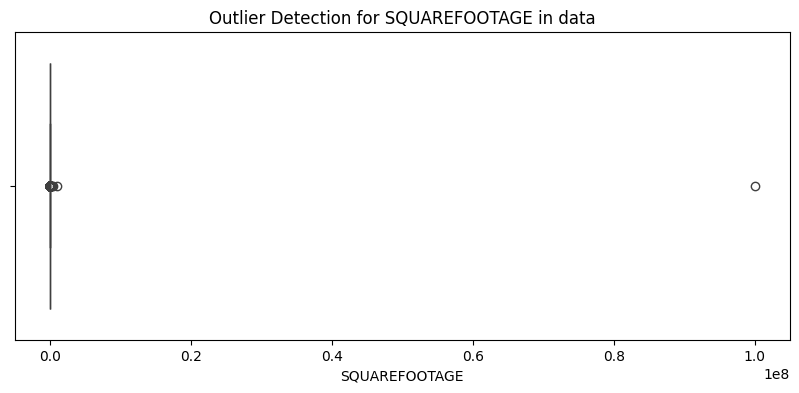

In [153]:
# Outlier Detection and Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Loop through each dataset in list_data
for name, df in list_data:
    print(f"Dataset: {name}")
    
    # Create a list to hold columns with outliers
    outlier_features = []

    # Loop through numeric columns
    for col in df.select_dtypes(include='number').columns:
        mean = df[col].mean()
        std = df[col].std()

        # Z-score based threshold
        lower = mean - (3 * std)
        upper = mean + (3 * std)

        # Detect outliers
        outliers = df[(df[col] < lower) | (df[col] > upper)]

        # Print summary
        print(f"Column: {col}, Outliers: {len(outliers)}")

        # If outliers found, add to list for boxplot
        if len(outliers) > 0:
            outlier_features.append(col)

        print('-' * 50)

    print('_' * 50)

    # Visualize outlier columns using boxplots
    for col in outlier_features:
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=data[col])
        plt.title(f'Outlier Detection for {col} in {name}')
        plt.show()

**HANDLING DUPLICATES, MISSING VALUES AND OUTLIER TREATMENT**

In [154]:
# Data Cleaning Steps

# STEP 1: Drop rows with critical missing values (rows can't be reliably fixed)
data = data.dropna(subset=["BEDROOMS", "BATHROOMS", "COUNTYFIPS"]).copy()

# STEP 2: Fix FIPS Codes and ZIP formatting (avoid cosmetic differences)
data["ZIPCODE"] = data["ZIPCODE"].astype(str).str.zfill(5)
data["STATEFIPS"] = data["STATEFIPS"].astype(str).str.zfill(2)
data["COUNTYFIPS"] = pd.to_numeric(data["COUNTYFIPS"], errors="coerce").astype("Int64").astype(str).str.zfill(3)

# STEP 3: Clean BEDROOMS (Clean early before group imputation next)
data["BEDROOMS"] = pd.to_numeric(data["BEDROOMS"], errors="coerce")
data.loc[data["BEDROOMS"] < 0, "BEDROOMS"] = pd.NA
data["BEDROOMS"] = data["BEDROOMS"].clip(0, 12).round().astype("Int64")

# STEP 4: Clean BATHROOMS
data["BATHROOMS"] = pd.to_numeric(data["BATHROOMS"], errors="coerce")
data.loc[data["BATHROOMS"] <= 0, "BATHROOMS"] = pd.NA
data["BATHROOMS"] = data["BATHROOMS"].clip(0.5, 10)

# STEP 5: Impute missing SQUAREFOOTAGE (imputation based on PROPERTYTYPE and BEDROOMS)
group_median = data.groupby(["PROPERTYTYPE", "BEDROOMS"])["SQUAREFOOTAGE"].transform("median")
data["SQUAREFOOTAGE"] = data["SQUAREFOOTAGE"].fillna(group_median)
data["SQUAREFOOTAGE"] = data["SQUAREFOOTAGE"].fillna(data["SQUAREFOOTAGE"].median())

# STEP 6: Cap DAYSONMARKET
data["DAYSONMARKET"] = pd.to_numeric(data["DAYSONMARKET"], errors="coerce")
data["DAYSONMARKET"] = data["DAYSONMARKET"].clip(lower=0, upper=365)

# STEP 7: Clean LATITUDE & LONGITUDE using clipping (avoid NaNs)
data["LATITUDE"] = data["LATITUDE"].clip(24, 50)
data["LONGITUDE"] = data["LONGITUDE"].clip(-125, -66)

# STEP 8: Cap Outliers (Winsorization) for selected features (PRICE, SQUAREFOOTAGE)
def cap_outliers(df, col, lower_quantile=0.05, upper_quantile=0.95):
    lower = df[col].quantile(lower_quantile)
    upper = df[col].quantile(upper_quantile)
    df[col] = df[col].clip(lower, upper)
    return df

for col in ["PRICE", "SQUAREFOOTAGE"]:
    if col in data.columns:
        data = cap_outliers(data, col)

# STEP 9: Final Drop Duplicates (avoid accidental duplicates)
data = data.drop_duplicates()

# Reset index (tidy output and avoiding confusion)
data = data.reset_index(drop=True)


Remaining Duplicates: 0


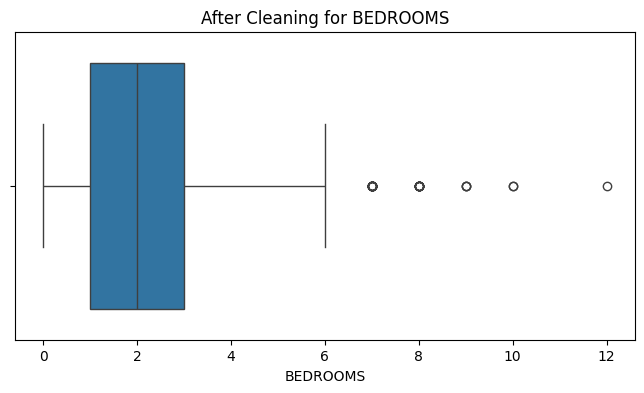

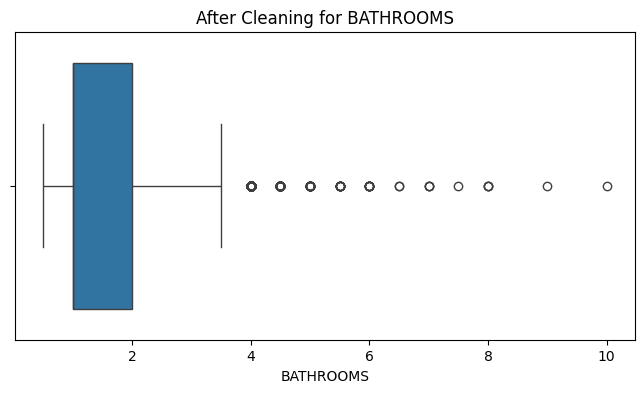

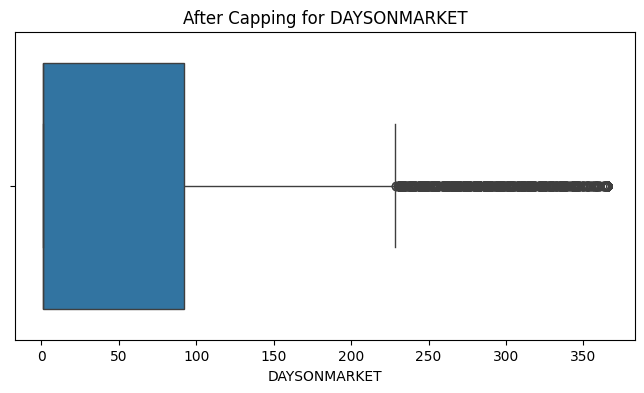

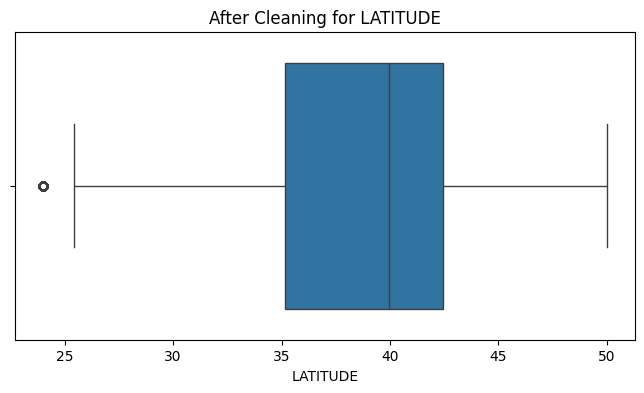

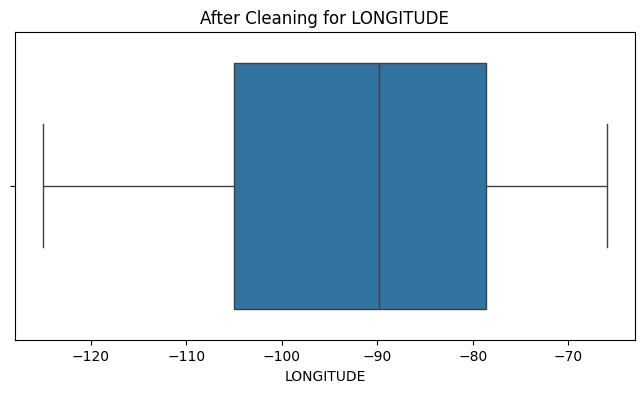

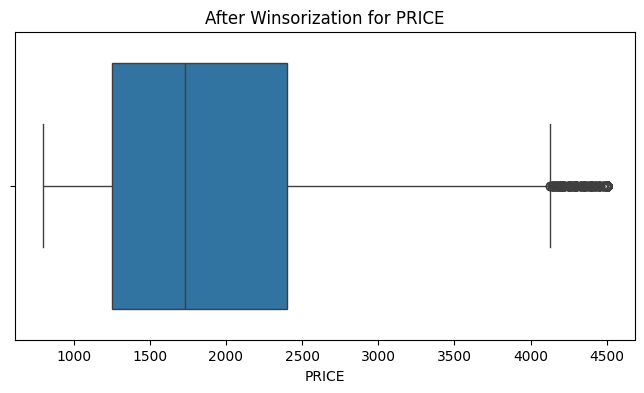

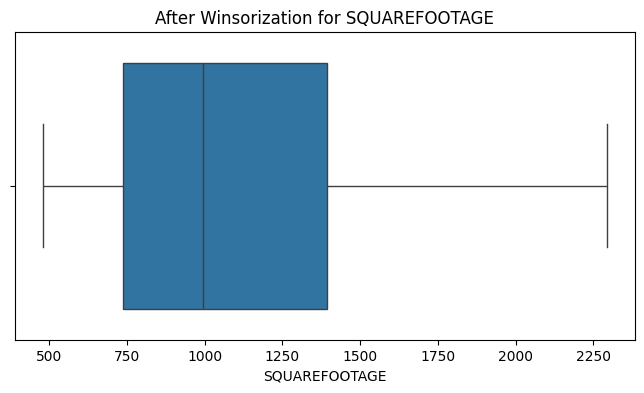

In [155]:
# Visualizations after cleaning steps

# Function to plot boxplots for a list of columns
def plot_boxplots(columns, title_prefix="Boxplot after Cleaning for"):
    for col in columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=data[col])
        plt.title(f"{title_prefix} {col}")
        plt.xlabel(col)
        plt.show()

# Print duplicates count
print(f"Remaining Duplicates: {data.duplicated().sum()}")

# Step 3: BEDROOMS
plot_boxplots(["BEDROOMS"], title_prefix="After Cleaning for")

# Step 4: BATHROOMS
plot_boxplots(["BATHROOMS"], title_prefix="After Cleaning for")

# Step 6: DAYSONMARKET
plot_boxplots(["DAYSONMARKET"], title_prefix="After Capping for")

# Step 7: LATITUDE & LONGITUDE
plot_boxplots(["LATITUDE", "LONGITUDE"], title_prefix="After Cleaning for")

# Step 8: PRICE & SQUAREFOOTAGE
plot_boxplots(["PRICE", "SQUAREFOOTAGE"], title_prefix="After Winsorization for")


**JUSTIFICATION**

**Price Winsorisation**:

a. PRICE: Extreme values of PRICE were addressed using winsorization at the 5th and 95th percentiles due to the heavily right‑skewed distribution. This approach limits the influence of unusually high-price listings while preserving the central price distribution; the remaining outliers fall within realistic market bounds and reflect natural variation in higher‑end properties rather than data errors, resulting in more stable and robust modeling.

b. SQUAREFOOTAGE: SQUAREFOOTAGE values was capped square footage at the 5th and 95th percentiles to reduce the impact of extreme outliers while retaining rare but realistic large properties in the dataset. This balances data quality and real-world representation

**Rule based Clip**

a. DAYSONMARKET : Days on Market was capped at 365 to reduce the impact of stale/poorly maintained listings and extreme tail values that hurt generalisation. Capping reduces sensitivity to data errors/outliers, improve model robustness and preserve the majority of observations unchanged. Despite capped at 365 days to reflect realistic market limits, the statistical outliers still appear due to IQR thresholds.

b. BEDROOMS: BEDROOMS was clipped between 0–12 to remove invalid/implausible values and prevent rare extreme entries from skewing the pricing model. The rare but valid high-bedroom listings were preserved as meaningful outliers.

c. BATHROOMS: BATHROOM values was clipped to 0.5–10 to remove data entry errors, filter unrealistic counts while preserving valid high-end properties and half-bath increments for modelling. These strike a balance between data quality control and retaining real-world diversity.

d. Latitude and longitude were range-validated by setting and capping coordinates outside expected US bounds (LAT 24–50, LON −125 to −66), which is why the post-cleaning boxplots did not show the impossible values (e.g., ~65 latitude and positive/very extreme longitudes) and retain only a realistic geographic spread.

In [156]:
# Check remaining missing values
print("Missing values (after cleaning):")
print(data.isna().sum())

print("Duplicated rows:", data.duplicated().sum())

# Check data structure
data.info()


Missing values (after cleaning):
CITY             0
PRICE            0
STATE            0
COUNTY           0
ZIPCODE          0
BEDROOMS         0
LATITUDE         0
BATHROOMS        0
LONGITUDE        0
STATEFIPS        0
COUNTYFIPS       0
LISTEDDATE       0
CREATEDDATE      0
LISTINGTYPE      0
ADDRESSLINE1     0
DAYSONMARKET     0
LASTSEENDATE     0
PROPERTYTYPE     0
SQUAREFOOTAGE    0
dtype: int64
Duplicated rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23791 entries, 0 to 23790
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CITY           23791 non-null  object 
 1   PRICE          23791 non-null  int64  
 2   STATE          23791 non-null  object 
 3   COUNTY         23791 non-null  object 
 4   ZIPCODE        23791 non-null  object 
 5   BEDROOMS       23791 non-null  Int64  
 6   LATITUDE       23791 non-null  float64
 7   BATHROOMS      23791 non-null  float64
 8   LONGITUDE      23791

In [157]:
import os

# # Save the cleaned data into the 'model' folder
# Relative path from current directory to model folder
save_path = "../model/cleaned_data.csv"

# Ensure directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save cleaned data
data.to_csv(save_path, index=False)